In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1572
0
(201296, 1, 32) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 256) (201296,) (201296,)
(49444, 1, 32) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 256) (49444,) (49444,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38609	valid-rmse:2.42534
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.982085	valid-rmse:0.996746
[100]	train-rmse:0.574703	valid-rmse:0.586572
[150]	train-rmse:0.491254	valid-rmse:0.50792
[200]	train-rmse:0.475287	valid-rmse:0.496638
[250]	train-rmse:0.46975	valid-rmse:0.495284
[300]	train-rmse:0.465553	valid-rmse:0.495132
[350]	train-rmse:0.462288	valid-rmse:0.495194
Stopping. Best iteration:
[306]	train-rmse:0.465127	valid-rmse:0.495105

0.21634287 0.2451292
[0.2451292]
-1 mean score 0.2451292
0.195526003838


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919995  0.009115  0.210097    7  2017-04-16
472     2.507290  2.522073 -0.014783  0.202383    1  2017-04-17
473     2.661330  2.655765  0.005565  0.231113    2  2017-04-18
474     2.754815  2.745653  0.009162  0.196696    3  2017-04-19
475     2.713762  2.708118  0.005644  0.217116    4  2017-04-20
476     2.999000  2.987078  0.011922  0.142906    5  2017-04-21
477     3.075529  3.082010 -0.006481  0.168371    6  2017-04-22

0.195526003838


pred         y     error    error2  day        date
dayidx                                                         
471     2.919995  2.929110  0.009115  0.210097    7  2017-04-16
472     2.522073  2.507290 -0.014783  0.202383    1  2017-04-17
473     2.655765  2.661330  0.005565  0.231113    2  2017-04-18
474     2.745653  2.754815  0.009162  0.196696    3  2017-04-19
475     2.708118  2.713762  0.005644  0.217116    4  2017-04-20
476     2.987078  2.999000  0.011922  0.142906    5  2017-04-21
477     3.082010  3.075529 -0.006481  0.168371    6  2017-04-22

(829, 256)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201067, 2) (49390, 2)
train/valid # (201067, 2) (49390, 2)
rand split across time
train has 201067 records out of 389630 records
valid has 49390 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1570
0
(201067, 1, 32) (201067, 7, 32) (201067, 1) (201067, 1)
(201067, 256) (201067,) (201067,)
(49390, 1, 32) (49390, 7, 32) (49390, 1) (49390, 1)
(49390, 256) (49390,) (49390,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38592	valid-rmse:2.4252
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985923	valid-rmse:1.00039
[100]	train-rmse:0.580622	valid-rmse:0.591892
[150]	train-rmse:0.497275	valid-rmse:0.512912
[200]	train-rmse:0.480484	valid-rmse:0.501215
[250]	train-rmse:0.474453	valid-rmse:0.499557
[300]	train-rmse:0.469695	valid-rmse:0.49933
[350]	train-rmse:0.466066	valid-rmse:0.499256
Stopping. Best iteration:
[342]	train-rmse:0.466744	valid-rmse:0.499195

0.21785 0.24919546
[0.24919546]
-1 mean score 0.24919546
0.198096826673


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918144  0.010966  0.215842    7  2017-04-16
472     2.507290  2.530792 -0.023502  0.204140    1  2017-04-17
473     2.661330  2.663015 -0.001686  0.233385    2  2017-04-18
474     2.754815  2.745898  0.008917  0.199999    3  2017-04-19
475     2.713762  2.721714 -0.007953  0.220638    4  2017-04-20
476     2.999000  2.992296  0.006704  0.143513    5  2017-04-21
477     3.075529  3.076483 -0.000953  0.169161    6  2017-04-22

0.198096826673


pred         y     error    error2  day        date
dayidx                                                         
471     2.918144  2.929110  0.010966  0.215842    7  2017-04-16
472     2.530792  2.507290 -0.023502  0.204140    1  2017-04-17
473     2.663015  2.661330 -0.001686  0.233385    2  2017-04-18
474     2.745898  2.754815  0.008917  0.199999    3  2017-04-19
475     2.721714  2.713762 -0.007953  0.220638    4  2017-04-20
476     2.992296  2.999000  0.006704  0.143513    5  2017-04-21
477     3.076483  3.075529 -0.000953  0.169161    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200884, 2) (49346, 2)
train/valid # (200884, 2) (49346, 2)
rand split across time
train has 200884 records out of 389630 records
valid has 49346 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1569
0
(200884, 1, 32) (200884, 7, 32) (200884, 1) (200884, 1)
(200884, 256) (200884,) (200884,)
(49346, 1, 32) (49346, 7, 32) (49346, 1) (49346, 1)
(49346, 256) (49346,) (49346,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38573	valid-rmse:2.425
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986791	valid-rmse:1.00126
[100]	train-rmse:0.582304	valid-rmse:0.59441
[150]	train-rmse:0.499079	valid-rmse:0.515796
[200]	train-rmse:0.482559	valid-rmse:0.504123
[250]	train-rmse:0.476182	valid-rmse:0.502422
[300]	train-rmse:0.472056	valid-rmse:0.502197
Stopping. Best iteration:
[291]	train-rmse:0.472646	valid-rmse:0.502194

0.22339469 0.25219923
[0.25219923]
-1 mean score 0.25219923
0.206101417542


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891987  0.037123  0.218987    7  2017-04-16
472     2.507290  2.519181 -0.011890  0.215020    1  2017-04-17
473     2.661330  2.646121  0.015209  0.250256    2  2017-04-18
474     2.754815  2.755256 -0.000442  0.213374    3  2017-04-19
475     2.713762  2.713534  0.000228  0.222955    4  2017-04-20
476     2.999000  2.990574  0.008426  0.148040    5  2017-04-21
477     3.075529  3.070153  0.005376  0.174079    6  2017-04-22

0.206101417542


pred         y     error    error2  day        date
dayidx                                                         
471     2.891987  2.929110  0.037123  0.218987    7  2017-04-16
472     2.519181  2.507290 -0.011890  0.215020    1  2017-04-17
473     2.646121  2.661330  0.015209  0.250256    2  2017-04-18
474     2.755256  2.754815 -0.000442  0.213374    3  2017-04-19
475     2.713534  2.713762  0.000228  0.222955    4  2017-04-20
476     2.990574  2.999000  0.008426  0.148040    5  2017-04-21
477     3.070153  3.075529  0.005376  0.174079    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200719, 2) (49309, 2)
train/valid # (200719, 2) (49309, 2)
rand split across time
train has 200719 records out of 389630 records
valid has 49309 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1568
0
(200719, 1, 32) (200719, 7, 32) (200719, 1) (200719, 1)
(200719, 256) (200719,) (200719,)
(49309, 1, 32) (49309, 7, 32) (49309, 1) (49309, 1)
(49309, 256) (49309,) (49309,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38576	valid-rmse:2.42493
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987904	valid-rmse:1.00085
[100]	train-rmse:0.584104	valid-rmse:0.594324
[150]	train-rmse:0.500876	valid-rmse:0.516398
[200]	train-rmse:0.484049	valid-rmse:0.505002
[250]	train-rmse:0.477792	valid-rmse:0.503381
[300]	train-rmse:0.473929	valid-rmse:0.503081
[350]	train-rmse:0.470571	valid-rmse:0.503028
[400]	train-rmse:0.467365	valid-rmse:0.502949
[450]	train-rmse:0.46408	valid-rmse:0.502913
[500]	train-rmse:0.461116	valid-rmse:0.502966
Stopping. Best iteration:
[465]	train-rmse:0.463099	valid-rmse:0.502898

0.21446045 0.2529069
[0.2529069]
-1 mean 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915628  0.013482  0.207195    7  2017-04-16
472     2.507290  2.516805 -0.009514  0.198856    1  2017-04-17
473     2.661330  2.651598  0.009732  0.226259    2  2017-04-18
474     2.754815  2.754007  0.000808  0.197658    3  2017-04-19
475     2.713762  2.725690 -0.011928  0.212139    4  2017-04-20
476     2.999000  2.991633  0.007367  0.140470    5  2017-04-21
477     3.075529  3.080091 -0.004562  0.160262    6  2017-04-22

0.19183395803


pred         y     error    error2  day        date
dayidx                                                         
471     2.915628  2.929110  0.013482  0.207195    7  2017-04-16
472     2.516805  2.507290 -0.009514  0.198856    1  2017-04-17
473     2.651598  2.661330  0.009732  0.226259    2  2017-04-18
474     2.754007  2.754815  0.000808  0.197658    3  2017-04-19
475     2.725690  2.713762 -0.011928  0.212139    4  2017-04-20
476     2.991633  2.999000  0.007367  0.140470    5  2017-04-21
477     3.080091  3.075529 -0.004562  0.160262    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200518, 2) (49258, 2)
train/valid # (200518, 2) (49258, 2)
rand split across time
train has 200518 records out of 389630 records
valid has 49258 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200518, 1, 32) (200518, 7, 32) (200518, 1) (200518, 1)
(200518, 256) (200518,) (200518,)
(49258, 1, 32) (49258, 7, 32) (49258, 1) (49258, 1)
(49258, 256) (49258,) (49258,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.386	valid-rmse:2.42507
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988982	valid-rmse:1.00308
[100]	train-rmse:0.585349	valid-rmse:0.596755
[150]	train-rmse:0.502067	valid-rmse:0.518452
[200]	train-rmse:0.485512	valid-rmse:0.507019
[250]	train-rmse:0.479315	valid-rmse:0.505406
[300]	train-rmse:0.474857	valid-rmse:0.505121
[350]	train-rmse:0.471196	valid-rmse:0.505133
Stopping. Best iteration:
[320]	train-rmse:0.473451	valid-rmse:0.50508

0.22415604 0.25510573
[0.25510573]
-1 mean score 0.25510573
0.20103302598


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903084  0.026026  0.214197    7  2017-04-16
472     2.507290  2.524688 -0.017397  0.209801    1  2017-04-17
473     2.661330  2.634795  0.026534  0.240159    2  2017-04-18
474     2.754815  2.743798  0.011017  0.203092    3  2017-04-19
475     2.713762  2.716095 -0.002334  0.224897    4  2017-04-20
476     2.999000  2.986906  0.012094  0.147938    5  2017-04-21
477     3.075529  3.074847  0.000683  0.167147    6  2017-04-22

0.20103302598


pred         y     error    error2  day        date
dayidx                                                         
471     2.903084  2.929110  0.026026  0.214197    7  2017-04-16
472     2.524688  2.507290 -0.017397  0.209801    1  2017-04-17
473     2.634795  2.661330  0.026534  0.240159    2  2017-04-18
474     2.743798  2.754815  0.011017  0.203092    3  2017-04-19
475     2.716095  2.713762 -0.002334  0.224897    4  2017-04-20
476     2.986906  2.999000  0.012094  0.147938    5  2017-04-21
477     3.074847  3.075529  0.000683  0.167147    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200306, 2) (49207, 2)
train/valid # (200306, 2) (49207, 2)
rand split across time
train has 200306 records out of 389630 records
valid has 49207 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1564
0
(200306, 1, 32) (200306, 7, 32) (200306, 1) (200306, 1)
(200306, 256) (200306,) (200306,)
(49207, 1, 32) (49207, 7, 32) (49207, 1) (49207, 1)
(49207, 256) (49207,) (49207,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38612	valid-rmse:2.42546
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989317	valid-rmse:1.0046
[100]	train-rmse:0.586153	valid-rmse:0.598262
[150]	train-rmse:0.5028	valid-rmse:0.51961
[200]	train-rmse:0.486034	valid-rmse:0.507812
[250]	train-rmse:0.479925	valid-rmse:0.506043
[300]	train-rmse:0.475529	valid-rmse:0.505877
Stopping. Best iteration:
[279]	train-rmse:0.477194	valid-rmse:0.505829

0.22771403 0.25586328
[0.25586328]
-1 mean score 0.25586328
0.209180131555


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907109  0.022001  0.222515    7  2017-04-16
472     2.507290  2.533471 -0.026180  0.222901    1  2017-04-17
473     2.661330  2.633376  0.027954  0.249242    2  2017-04-18
474     2.754815  2.731944  0.022870  0.208203    3  2017-04-19
475     2.713762  2.710238  0.003524  0.233489    4  2017-04-20
476     2.999000  2.968614  0.030386  0.155081    5  2017-04-21
477     3.075529  3.077682 -0.002153  0.172829    6  2017-04-22

0.209180131555


pred         y     error    error2  day        date
dayidx                                                         
471     2.907109  2.929110  0.022001  0.222515    7  2017-04-16
472     2.533471  2.507290 -0.026180  0.222901    1  2017-04-17
473     2.633376  2.661330  0.027954  0.249242    2  2017-04-18
474     2.731944  2.754815  0.022870  0.208203    3  2017-04-19
475     2.710238  2.713762  0.003524  0.233489    4  2017-04-20
476     2.968614  2.999000  0.030386  0.155081    5  2017-04-21
477     3.077682  3.075529 -0.002153  0.172829    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200088, 2) (49151, 2)
train/valid # (200088, 2) (49151, 2)
rand split across time
train has 200088 records out of 389630 records
valid has 49151 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1563
0
(200088, 1, 32) (200088, 7, 32) (200088, 1) (200088, 1)
(200088, 256) (200088,) (200088,)
(49151, 1, 32) (49151, 7, 32) (49151, 1) (49151, 1)
(49151, 256) (49151,) (49151,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38625	valid-rmse:2.42549
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990498	valid-rmse:1.00471
[100]	train-rmse:0.58799	valid-rmse:0.599133
[150]	train-rmse:0.505165	valid-rmse:0.521081
[200]	train-rmse:0.48888	valid-rmse:0.509632
[250]	train-rmse:0.483016	valid-rmse:0.508049
[300]	train-rmse:0.478236	valid-rmse:0.507809
[350]	train-rmse:0.474605	valid-rmse:0.507835
Stopping. Best iteration:
[301]	train-rmse:0.478106	valid-rmse:0.507782

0.22858526 0.2578423
[0.2578423]
-1 mean score 0.2578423
0.209766790271


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907790  0.021320  0.223840    7  2017-04-16
472     2.507290  2.541229 -0.033939  0.222444    1  2017-04-17
473     2.661330  2.641914  0.019416  0.248490    2  2017-04-18
474     2.754815  2.736555  0.018260  0.210188    3  2017-04-19
475     2.713762  2.708650  0.005112  0.233627    4  2017-04-20
476     2.999000  2.978297  0.020703  0.150115    5  2017-04-21
477     3.075529  3.095877 -0.020348  0.179663    6  2017-04-22

0.209766790271


pred         y     error    error2  day        date
dayidx                                                         
471     2.907790  2.929110  0.021320  0.223840    7  2017-04-16
472     2.541229  2.507290 -0.033939  0.222444    1  2017-04-17
473     2.641914  2.661330  0.019416  0.248490    2  2017-04-18
474     2.736555  2.754815  0.018260  0.210188    3  2017-04-19
475     2.708650  2.713762  0.005112  0.233627    4  2017-04-20
476     2.978297  2.999000  0.020703  0.150115    5  2017-04-21
477     3.095877  3.075529 -0.020348  0.179663    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199858, 2) (49091, 2)
train/valid # (199858, 2) (49091, 2)
rand split across time
train has 199858 records out of 389630 records
valid has 49091 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0
(199858, 1, 32) (199858, 7, 32) (199858, 1) (199858, 1)
(199858, 256) (199858,) (199858,)
(49091, 1, 32) (49091, 7, 32) (49091, 1) (49091, 1)
(49091, 256) (49091,) (49091,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38617	valid-rmse:2.42531
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991161	valid-rmse:1.00402
[100]	train-rmse:0.590171	valid-rmse:0.601386
[150]	train-rmse:0.508281	valid-rmse:0.525102
[200]	train-rmse:0.491651	valid-rmse:0.514011
[250]	train-rmse:0.485898	valid-rmse:0.512472
[300]	train-rmse:0.481081	valid-rmse:0.512236
Stopping. Best iteration:
[287]	train-rmse:0.482092	valid-rmse:0.512218

0.23241314 0.26236725
[0.26236725]
-1 mean score 0.26236725
0.213144749403


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924282  0.004828  0.236495    7  2017-04-16
472     2.507290  2.537959 -0.030668  0.220630    1  2017-04-17
473     2.661330  2.642879  0.018451  0.251497    2  2017-04-18
474     2.754815  2.739149  0.015666  0.217549    3  2017-04-19
475     2.713762  2.709016  0.004746  0.233693    4  2017-04-20
476     2.999000  2.963943  0.035056  0.156195    5  2017-04-21
477     3.075529  3.086533 -0.011004  0.175954    6  2017-04-22

0.213144749403


pred         y     error    error2  day        date
dayidx                                                         
471     2.924282  2.929110  0.004828  0.236495    7  2017-04-16
472     2.537959  2.507290 -0.030668  0.220630    1  2017-04-17
473     2.642879  2.661330  0.018451  0.251497    2  2017-04-18
474     2.739149  2.754815  0.015666  0.217549    3  2017-04-19
475     2.709016  2.713762  0.004746  0.233693    4  2017-04-20
476     2.963943  2.999000  0.035056  0.156195    5  2017-04-21
477     3.086533  3.075529 -0.011004  0.175954    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199635, 2) (49032, 2)
train/valid # (199635, 2) (49032, 2)
rand split across time
train has 199635 records out of 389630 records
valid has 49032 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1559
0
(199635, 1, 32) (199635, 7, 32) (199635, 1) (199635, 1)
(199635, 256) (199635,) (199635,)
(49032, 1, 32) (49032, 7, 32) (49032, 1) (49032, 1)
(49032, 256) (49032,) (49032,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38585	valid-rmse:2.42502
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99234	valid-rmse:1.00547
[100]	train-rmse:0.59223	valid-rmse:0.60265
[150]	train-rmse:0.510277	valid-rmse:0.526339
[200]	train-rmse:0.493795	valid-rmse:0.515426
[250]	train-rmse:0.487995	valid-rmse:0.513927
[300]	train-rmse:0.483352	valid-rmse:0.513599
[350]	train-rmse:0.479688	valid-rmse:0.513594
Stopping. Best iteration:
[332]	train-rmse:0.481003	valid-rmse:0.513565

0.2313635 0.26374945
[0.26374945]
-1 mean score 0.26374945
0.212318971753


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925175  0.003935  0.232094    7  2017-04-16
472     2.507290  2.541002 -0.033712  0.226132    1  2017-04-17
473     2.661330  2.666513 -0.005184  0.253497    2  2017-04-18
474     2.754815  2.742138  0.012677  0.215405    3  2017-04-19
475     2.713762  2.728482 -0.014720  0.228254    4  2017-04-20
476     2.999000  2.973651  0.025349  0.156072    5  2017-04-21
477     3.075529  3.080474 -0.004945  0.174779    6  2017-04-22

0.212318971753


pred         y     error    error2  day        date
dayidx                                                         
471     2.925175  2.929110  0.003935  0.232094    7  2017-04-16
472     2.541002  2.507290 -0.033712  0.226132    1  2017-04-17
473     2.666513  2.661330 -0.005184  0.253497    2  2017-04-18
474     2.742138  2.754815  0.012677  0.215405    3  2017-04-19
475     2.728482  2.713762 -0.014720  0.228254    4  2017-04-20
476     2.973651  2.999000  0.025349  0.156072    5  2017-04-21
477     3.080474  3.075529 -0.004945  0.174779    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199462, 2) (48989, 2)
train/valid # (199462, 2) (48989, 2)
rand split across time
train has 199462 records out of 389630 records
valid has 48989 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1558
0
(199462, 1, 32) (199462, 7, 32) (199462, 1) (199462, 1)
(199462, 256) (199462,) (199462,)
(48989, 1, 32) (48989, 7, 32) (48989, 1) (48989, 1)
(48989, 256) (48989,) (48989,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38584	valid-rmse:2.42511
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992899	valid-rmse:1.00742
[100]	train-rmse:0.593524	valid-rmse:0.605006
[150]	train-rmse:0.511766	valid-rmse:0.527925
[200]	train-rmse:0.495183	valid-rmse:0.516421
[250]	train-rmse:0.488818	valid-rmse:0.51475
[300]	train-rmse:0.4843	valid-rmse:0.514291
[350]	train-rmse:0.48044	valid-rmse:0.514145
[400]	train-rmse:0.476924	valid-rmse:0.514136
Stopping. Best iteration:
[375]	train-rmse:0.478647	valid-rmse:0.514116

0.2291028 0.26431534
[0.26431534]
-1 mean score 0.26431534
0.208488568664


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923667  0.005443  0.226497    7  2017-04-16
472     2.507290  2.530281 -0.022990  0.216919    1  2017-04-17
473     2.661330  2.667985 -0.006655  0.252275    2  2017-04-18
474     2.754815  2.757730 -0.002915  0.212245    3  2017-04-19
475     2.713762  2.731638 -0.017877  0.225115    4  2017-04-20
476     2.999000  2.978981  0.020018  0.153457    5  2017-04-21
477     3.075529  3.086830 -0.011301  0.172912    6  2017-04-22

0.208488568664


pred         y     error    error2  day        date
dayidx                                                         
471     2.923667  2.929110  0.005443  0.226497    7  2017-04-16
472     2.530281  2.507290 -0.022990  0.216919    1  2017-04-17
473     2.667985  2.661330 -0.006655  0.252275    2  2017-04-18
474     2.757730  2.754815 -0.002915  0.212245    3  2017-04-19
475     2.731638  2.713762 -0.017877  0.225115    4  2017-04-20
476     2.978981  2.999000  0.020018  0.153457    5  2017-04-21
477     3.086830  3.075529 -0.011301  0.172912    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199280, 2) (48945, 2)
train/valid # (199280, 2) (48945, 2)
rand split across time
train has 199280 records out of 389630 records
valid has 48945 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1556
0
(199280, 1, 32) (199280, 7, 32) (199280, 1) (199280, 1)
(199280, 256) (199280,) (199280,)
(48945, 1, 32) (48945, 7, 32) (48945, 1) (48945, 1)
(48945, 256) (48945,) (48945,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38614	valid-rmse:2.42543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993678	valid-rmse:1.00674
[100]	train-rmse:0.594094	valid-rmse:0.60495
[150]	train-rmse:0.512092	valid-rmse:0.528812
[200]	train-rmse:0.495516	valid-rmse:0.517748
[250]	train-rmse:0.489076	valid-rmse:0.516196
[300]	train-rmse:0.48426	valid-rmse:0.515851
[350]	train-rmse:0.479944	valid-rmse:0.515752
[400]	train-rmse:0.476251	valid-rmse:0.515727
[450]	train-rmse:0.472902	valid-rmse:0.515764
Stopping. Best iteration:
[401]	train-rmse:0.476126	valid-rmse:0.515708

0.22669595 0.26595446
[0.26595446]
-1 mean score 0.26595446
0.207718998194


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915071  0.014039  0.222414    7  2017-04-16
472     2.507290  2.538168 -0.030877  0.213052    1  2017-04-17
473     2.661330  2.666303 -0.004973  0.257254    2  2017-04-18
474     2.754815  2.750680  0.004135  0.208571    3  2017-04-19
475     2.713762  2.745831 -0.032070  0.225684    4  2017-04-20
476     2.999000  2.983190  0.015809  0.155653    5  2017-04-21
477     3.075529  3.076782 -0.001252  0.171405    6  2017-04-22

0.207718998194


pred         y     error    error2  day        date
dayidx                                                         
471     2.915071  2.929110  0.014039  0.222414    7  2017-04-16
472     2.538168  2.507290 -0.030877  0.213052    1  2017-04-17
473     2.666303  2.661330 -0.004973  0.257254    2  2017-04-18
474     2.750680  2.754815  0.004135  0.208571    3  2017-04-19
475     2.745831  2.713762 -0.032070  0.225684    4  2017-04-20
476     2.983190  2.999000  0.015809  0.155653    5  2017-04-21
477     3.076782  3.075529 -0.001252  0.171405    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199068, 2) (48890, 2)
train/valid # (199068, 2) (48890, 2)
rand split across time
train has 199068 records out of 389630 records
valid has 48890 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1555
0
(199068, 1, 32) (199068, 7, 32) (199068, 1) (199068, 1)
(199068, 256) (199068,) (199068,)
(48890, 1, 32) (48890, 7, 32) (48890, 1) (48890, 1)
(48890, 256) (48890,) (48890,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38634	valid-rmse:2.42551
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994635	valid-rmse:1.0071
[100]	train-rmse:0.595168	valid-rmse:0.605974
[150]	train-rmse:0.513293	valid-rmse:0.530178
[200]	train-rmse:0.49629	valid-rmse:0.519172
[250]	train-rmse:0.490096	valid-rmse:0.517625
[300]	train-rmse:0.485318	valid-rmse:0.517383
Stopping. Best iteration:
[294]	train-rmse:0.485796	valid-rmse:0.517354

0.23599796 0.26765507
[0.26765507]
-1 mean score 0.26765507
0.213715866208


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895733  0.033377  0.230485    7  2017-04-16
472     2.507290  2.537562 -0.030271  0.215318    1  2017-04-17
473     2.661330  2.662945 -0.001615  0.262307    2  2017-04-18
474     2.754815  2.730840  0.023975  0.220643    3  2017-04-19
475     2.713762  2.727994 -0.014232  0.229504    4  2017-04-20
476     2.999000  2.969613  0.029387  0.160786    5  2017-04-21
477     3.075529  3.075274  0.000255  0.176968    6  2017-04-22

0.213715866208


pred         y     error    error2  day        date
dayidx                                                         
471     2.895733  2.929110  0.033377  0.230485    7  2017-04-16
472     2.537562  2.507290 -0.030271  0.215318    1  2017-04-17
473     2.662945  2.661330 -0.001615  0.262307    2  2017-04-18
474     2.730840  2.754815  0.023975  0.220643    3  2017-04-19
475     2.727994  2.713762 -0.014232  0.229504    4  2017-04-20
476     2.969613  2.999000  0.029387  0.160786    5  2017-04-21
477     3.075274  3.075529  0.000255  0.176968    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198858, 2) (48837, 2)
train/valid # (198858, 2) (48837, 2)
rand split across time
train has 198858 records out of 389630 records
valid has 48837 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1553
0
(198858, 1, 32) (198858, 7, 32) (198858, 1) (198858, 1)
(198858, 256) (198858,) (198858,)
(48837, 1, 32) (48837, 7, 32) (48837, 1) (48837, 1)
(48837, 256) (48837,) (48837,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38647	valid-rmse:2.42575
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994733	valid-rmse:1.00882
[100]	train-rmse:0.595446	valid-rmse:0.607123
[150]	train-rmse:0.513202	valid-rmse:0.530553
[200]	train-rmse:0.496471	valid-rmse:0.519258
[250]	train-rmse:0.490139	valid-rmse:0.517595
[300]	train-rmse:0.48564	valid-rmse:0.517278
[350]	train-rmse:0.482531	valid-rmse:0.517229
Stopping. Best iteration:
[326]	train-rmse:0.484011	valid-rmse:0.517214

0.23426694 0.26751038
[0.26751038]
-1 mean score 0.26751038
0.21243520081


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904551  0.024559  0.230359    7  2017-04-16
472     2.507290  2.542132 -0.034842  0.218812    1  2017-04-17
473     2.661330  2.669893 -0.008563  0.259594    2  2017-04-18
474     2.754815  2.741264  0.013551  0.218150    3  2017-04-19
475     2.713762  2.729478 -0.015716  0.229279    4  2017-04-20
476     2.999000  2.984498  0.014502  0.157029    5  2017-04-21
477     3.075529  3.073817  0.001712  0.173823    6  2017-04-22

0.21243520081


pred         y     error    error2  day        date
dayidx                                                         
471     2.904551  2.929110  0.024559  0.230359    7  2017-04-16
472     2.542132  2.507290 -0.034842  0.218812    1  2017-04-17
473     2.669893  2.661330 -0.008563  0.259594    2  2017-04-18
474     2.741264  2.754815  0.013551  0.218150    3  2017-04-19
475     2.729478  2.713762 -0.015716  0.229279    4  2017-04-20
476     2.984498  2.999000  0.014502  0.157029    5  2017-04-21
477     3.073817  3.075529  0.001712  0.173823    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198636, 2) (48781, 2)
train/valid # (198636, 2) (48781, 2)
rand split across time
train has 198636 records out of 389630 records
valid has 48781 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1551
0
(198636, 1, 32) (198636, 7, 32) (198636, 1) (198636, 1)
(198636, 256) (198636,) (198636,)
(48781, 1, 32) (48781, 7, 32) (48781, 1) (48781, 1)
(48781, 256) (48781,) (48781,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38652	valid-rmse:2.42577
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995107	valid-rmse:1.00935
[100]	train-rmse:0.596396	valid-rmse:0.608061
[150]	train-rmse:0.51474	valid-rmse:0.531817
[200]	train-rmse:0.497969	valid-rmse:0.520735
[250]	train-rmse:0.491654	valid-rmse:0.519273
[300]	train-rmse:0.487125	valid-rmse:0.519094
Stopping. Best iteration:
[293]	train-rmse:0.487498	valid-rmse:0.51908

0.23765425 0.26944453
[0.26944453]
-1 mean score 0.26944453
0.214821189642


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889105  0.040005  0.237257    7  2017-04-16
472     2.507290  2.534219 -0.026928  0.219617    1  2017-04-17
473     2.661330  2.661677 -0.000347  0.260490    2  2017-04-18
474     2.754815  2.731221  0.023594  0.220885    3  2017-04-19
475     2.713762  2.724558 -0.010796  0.227989    4  2017-04-20
476     2.999000  2.989143  0.009857  0.154237    5  2017-04-21
477     3.075529  3.080133 -0.004604  0.183274    6  2017-04-22

0.214821189642


pred         y     error    error2  day        date
dayidx                                                         
471     2.889105  2.929110  0.040005  0.237257    7  2017-04-16
472     2.534219  2.507290 -0.026928  0.219617    1  2017-04-17
473     2.661677  2.661330 -0.000347  0.260490    2  2017-04-18
474     2.731221  2.754815  0.023594  0.220885    3  2017-04-19
475     2.724558  2.713762 -0.010796  0.227989    4  2017-04-20
476     2.989143  2.999000  0.009857  0.154237    5  2017-04-21
477     3.080133  3.075529 -0.004604  0.183274    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198406, 2) (48721, 2)
train/valid # (198406, 2) (48721, 2)
rand split across time
train has 198406 records out of 389630 records
valid has 48721 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1550
0
(198406, 1, 32) (198406, 7, 32) (198406, 1) (198406, 1)
(198406, 256) (198406,) (198406,)
(48721, 1, 32) (48721, 7, 32) (48721, 1) (48721, 1)
(48721, 256) (48721,) (48721,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38642	valid-rmse:2.42566
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995591	valid-rmse:1.01006
[100]	train-rmse:0.598136	valid-rmse:0.610256
[150]	train-rmse:0.517273	valid-rmse:0.5348
[200]	train-rmse:0.500539	valid-rmse:0.523673
[250]	train-rmse:0.49404	valid-rmse:0.522097
[300]	train-rmse:0.489043	valid-rmse:0.521989
[350]	train-rmse:0.48491	valid-rmse:0.521986
Stopping. Best iteration:
[331]	train-rmse:0.48628	valid-rmse:0.521972

0.23646854 0.27245468
[0.27245468]
-1 mean score 0.27245468
0.213779240847


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918005  0.011104  0.242372    7  2017-04-16
472     2.507290  2.538595 -0.031304  0.221439    1  2017-04-17
473     2.661330  2.660752  0.000578  0.258545    2  2017-04-18
474     2.754815  2.738050  0.016764  0.217374    3  2017-04-19
475     2.713762  2.733189 -0.019427  0.225768    4  2017-04-20
476     2.999000  2.998655  0.000345  0.154783    5  2017-04-21
477     3.075529  3.077538 -0.002009  0.176174    6  2017-04-22

0.213779240847


pred         y     error    error2  day        date
dayidx                                                         
471     2.918005  2.929110  0.011104  0.242372    7  2017-04-16
472     2.538595  2.507290 -0.031304  0.221439    1  2017-04-17
473     2.660752  2.661330  0.000578  0.258545    2  2017-04-18
474     2.738050  2.754815  0.016764  0.217374    3  2017-04-19
475     2.733189  2.713762 -0.019427  0.225768    4  2017-04-20
476     2.998655  2.999000  0.000345  0.154783    5  2017-04-21
477     3.077538  3.075529 -0.002009  0.176174    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198178, 2) (48660, 2)
train/valid # (198178, 2) (48660, 2)
rand split across time
train has 198178 records out of 389630 records
valid has 48660 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1548
0
(198178, 1, 32) (198178, 7, 32) (198178, 1) (198178, 1)
(198178, 256) (198178,) (198178,)
(48660, 1, 32) (48660, 7, 32) (48660, 1) (48660, 1)
(48660, 256) (48660,) (48660,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38624	valid-rmse:2.42516
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996993	valid-rmse:1.00999
[100]	train-rmse:0.600506	valid-rmse:0.610859
[150]	train-rmse:0.519708	valid-rmse:0.535743
[200]	train-rmse:0.502945	valid-rmse:0.524874
[250]	train-rmse:0.496138	valid-rmse:0.523371
[300]	train-rmse:0.491084	valid-rmse:0.523127
[350]	train-rmse:0.487775	valid-rmse:0.523071
[400]	train-rmse:0.48448	valid-rmse:0.523082
Stopping. Best iteration:
[387]	train-rmse:0.485399	valid-rmse:0.523043

0.23561254 0.27357346
[0.27357346]
-1 mean score 0.27357346
0.212559297681


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906456  0.022654  0.239006    7  2017-04-16
472     2.507290  2.544669 -0.037379  0.224309    1  2017-04-17
473     2.661330  2.659826  0.001504  0.255369    2  2017-04-18
474     2.754815  2.730431  0.024384  0.211393    3  2017-04-19
475     2.713762  2.733292 -0.019531  0.225396    4  2017-04-20
476     2.999000  2.993257  0.005743  0.155889    5  2017-04-21
477     3.075529  3.074862  0.000667  0.176554    6  2017-04-22

0.212559297681


pred         y     error    error2  day        date
dayidx                                                         
471     2.906456  2.929110  0.022654  0.239006    7  2017-04-16
472     2.544669  2.507290 -0.037379  0.224309    1  2017-04-17
473     2.659826  2.661330  0.001504  0.255369    2  2017-04-18
474     2.730431  2.754815  0.024384  0.211393    3  2017-04-19
475     2.733292  2.713762 -0.019531  0.225396    4  2017-04-20
476     2.993257  2.999000  0.005743  0.155889    5  2017-04-21
477     3.074862  3.075529  0.000667  0.176554    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198017, 2) (48619, 2)
train/valid # (198017, 2) (48619, 2)
rand split across time
train has 198017 records out of 389630 records
valid has 48619 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1547
0
(198017, 1, 32) (198017, 7, 32) (198017, 1) (198017, 1)
(198017, 256) (198017,) (198017,)
(48619, 1, 32) (48619, 7, 32) (48619, 1) (48619, 1)
(48619, 256) (48619,) (48619,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38625	valid-rmse:2.42501
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997237	valid-rmse:1.00996
[100]	train-rmse:0.60094	valid-rmse:0.61178
[150]	train-rmse:0.520209	valid-rmse:0.536938
[200]	train-rmse:0.503565	valid-rmse:0.526176
[250]	train-rmse:0.496581	valid-rmse:0.524663
[300]	train-rmse:0.491924	valid-rmse:0.524371
[350]	train-rmse:0.48812	valid-rmse:0.524317
[400]	train-rmse:0.484554	valid-rmse:0.524375
Stopping. Best iteration:
[351]	train-rmse:0.487966	valid-rmse:0.524314

0.23811057 0.2749054
[0.2749054]
-1 mean score 0.2749054
0.213605254889


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904371  0.024739  0.238498    7  2017-04-16
472     2.507290  2.527234 -0.019944  0.219166    1  2017-04-17
473     2.661330  2.649168  0.012162  0.258789    2  2017-04-18
474     2.754815  2.734243  0.020572  0.217190    3  2017-04-19
475     2.713762  2.729364 -0.015602  0.225910    4  2017-04-20
476     2.999000  2.994221  0.004779  0.159121    5  2017-04-21
477     3.075529  3.064150  0.011379  0.176562    6  2017-04-22

0.213605254889


pred         y     error    error2  day        date
dayidx                                                         
471     2.904371  2.929110  0.024739  0.238498    7  2017-04-16
472     2.527234  2.507290 -0.019944  0.219166    1  2017-04-17
473     2.649168  2.661330  0.012162  0.258789    2  2017-04-18
474     2.734243  2.754815  0.020572  0.217190    3  2017-04-19
475     2.729364  2.713762 -0.015602  0.225910    4  2017-04-20
476     2.994221  2.999000  0.004779  0.159121    5  2017-04-21
477     3.064150  3.075529  0.011379  0.176562    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197823, 2) (48577, 2)
train/valid # (197823, 2) (48577, 2)
rand split across time
train has 197823 records out of 389630 records
valid has 48577 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1545
0
(197823, 1, 32) (197823, 7, 32) (197823, 1) (197823, 1)
(197823, 256) (197823,) (197823,)
(48577, 1, 32) (48577, 7, 32) (48577, 1) (48577, 1)
(48577, 256) (48577,) (48577,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38653	valid-rmse:2.42526
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998147	valid-rmse:1.01056
[100]	train-rmse:0.601851	valid-rmse:0.612351
[150]	train-rmse:0.520735	valid-rmse:0.537794
[200]	train-rmse:0.503819	valid-rmse:0.526999
[250]	train-rmse:0.49669	valid-rmse:0.525462
[300]	train-rmse:0.491345	valid-rmse:0.525249
[350]	train-rmse:0.487098	valid-rmse:0.525244
Stopping. Best iteration:
[315]	train-rmse:0.489954	valid-rmse:0.525218

0.24005471 0.27585363
[0.27585363]
-1 mean score 0.27585363
0.21562692523


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903083  0.026027  0.240994    7  2017-04-16
472     2.507290  2.527447 -0.020156  0.220954    1  2017-04-17
473     2.661330  2.647185  0.014145  0.260807    2  2017-04-18
474     2.754815  2.725288  0.029527  0.213453    3  2017-04-19
475     2.713762  2.721523 -0.007761  0.231735    4  2017-04-20
476     2.999000  2.987881  0.011119  0.161500    5  2017-04-21
477     3.075529  3.059825  0.015705  0.179945    6  2017-04-22

0.21562692523


pred         y     error    error2  day        date
dayidx                                                         
471     2.903083  2.929110  0.026027  0.240994    7  2017-04-16
472     2.527447  2.507290 -0.020156  0.220954    1  2017-04-17
473     2.647185  2.661330  0.014145  0.260807    2  2017-04-18
474     2.725288  2.754815  0.029527  0.213453    3  2017-04-19
475     2.721523  2.713762 -0.007761  0.231735    4  2017-04-20
476     2.987881  2.999000  0.011119  0.161500    5  2017-04-21
477     3.059825  3.075529  0.015705  0.179945    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197614, 2) (48521, 2)
train/valid # (197614, 2) (48521, 2)
rand split across time
train has 197614 records out of 389630 records
valid has 48521 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1543
0
(197614, 1, 32) (197614, 7, 32) (197614, 1) (197614, 1)
(197614, 256) (197614,) (197614,)
(48521, 1, 32) (48521, 7, 32) (48521, 1) (48521, 1)
(48521, 256) (48521,) (48521,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38665	valid-rmse:2.4254
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99856	valid-rmse:1.01192
[100]	train-rmse:0.602371	valid-rmse:0.614131
[150]	train-rmse:0.521298	valid-rmse:0.539371
[200]	train-rmse:0.504159	valid-rmse:0.528333
[250]	train-rmse:0.496989	valid-rmse:0.52674
[300]	train-rmse:0.49207	valid-rmse:0.526409
[350]	train-rmse:0.488123	valid-rmse:0.526409
Stopping. Best iteration:
[322]	train-rmse:0.490208	valid-rmse:0.526354

0.2403034 0.2770488
[0.2770488]
-1 mean score 0.2770488
0.216688767076


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910086  0.019024  0.238802    7  2017-04-16
472     2.507290  2.541086 -0.033796  0.222379    1  2017-04-17
473     2.661330  2.649561  0.011768  0.253232    2  2017-04-18
474     2.754815  2.726794  0.028021  0.217701    3  2017-04-19
475     2.713762  2.726701 -0.012940  0.238310    4  2017-04-20
476     2.999000  2.975276  0.023723  0.165164    5  2017-04-21
477     3.075529  3.063426  0.012104  0.181233    6  2017-04-22

0.216688767076


pred         y     error    error2  day        date
dayidx                                                         
471     2.910086  2.929110  0.019024  0.238802    7  2017-04-16
472     2.541086  2.507290 -0.033796  0.222379    1  2017-04-17
473     2.649561  2.661330  0.011768  0.253232    2  2017-04-18
474     2.726794  2.754815  0.028021  0.217701    3  2017-04-19
475     2.726701  2.713762 -0.012940  0.238310    4  2017-04-20
476     2.975276  2.999000  0.023723  0.165164    5  2017-04-21
477     3.063426  3.075529  0.012104  0.181233    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197398, 2) (48463, 2)
train/valid # (197398, 2) (48463, 2)
rand split across time
train has 197398 records out of 389630 records
valid has 48463 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1542
0
(197398, 1, 32) (197398, 7, 32) (197398, 1) (197398, 1)
(197398, 256) (197398,) (197398,)
(48463, 1, 32) (48463, 7, 32) (48463, 1) (48463, 1)
(48463, 256) (48463,) (48463,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38672	valid-rmse:2.42543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998946	valid-rmse:1.01175
[100]	train-rmse:0.602896	valid-rmse:0.614375
[150]	train-rmse:0.521459	valid-rmse:0.53965
[200]	train-rmse:0.504269	valid-rmse:0.528559
[250]	train-rmse:0.497532	valid-rmse:0.527013
[300]	train-rmse:0.492799	valid-rmse:0.526726
[350]	train-rmse:0.488449	valid-rmse:0.526724
Stopping. Best iteration:
[334]	train-rmse:0.489828	valid-rmse:0.526687

0.23993146 0.2773989
[0.2773989]
-1 mean score 0.2773989
0.215616434813


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916631  0.012479  0.234990    7  2017-04-16
472     2.507290  2.542590 -0.035300  0.220583    1  2017-04-17
473     2.661330  2.651435  0.009895  0.258474    2  2017-04-18
474     2.754815  2.731525  0.023290  0.217551    3  2017-04-19
475     2.713762  2.722297 -0.008535  0.237398    4  2017-04-20
476     2.999000  2.970105  0.028895  0.163902    5  2017-04-21
477     3.075529  3.059253  0.016276  0.176417    6  2017-04-22

0.215616434813


pred         y     error    error2  day        date
dayidx                                                         
471     2.916631  2.929110  0.012479  0.234990    7  2017-04-16
472     2.542590  2.507290 -0.035300  0.220583    1  2017-04-17
473     2.651435  2.661330  0.009895  0.258474    2  2017-04-18
474     2.731525  2.754815  0.023290  0.217551    3  2017-04-19
475     2.722297  2.713762 -0.008535  0.237398    4  2017-04-20
476     2.970105  2.999000  0.028895  0.163902    5  2017-04-21
477     3.059253  3.075529  0.016276  0.176417    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197176, 2) (48404, 2)
train/valid # (197176, 2) (48404, 2)
rand split across time
train has 197176 records out of 389630 records
valid has 48404 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1540
0
(197176, 1, 32) (197176, 7, 32) (197176, 1) (197176, 1)
(197176, 256) (197176,) (197176,)
(48404, 1, 32) (48404, 7, 32) (48404, 1) (48404, 1)
(48404, 256) (48404,) (48404,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38679	valid-rmse:2.42568
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999365	valid-rmse:1.01373
[100]	train-rmse:0.603851	valid-rmse:0.615959
[150]	train-rmse:0.522948	valid-rmse:0.541014
[200]	train-rmse:0.506161	valid-rmse:0.530048
[250]	train-rmse:0.499148	valid-rmse:0.528478
[300]	train-rmse:0.494445	valid-rmse:0.528307
[350]	train-rmse:0.49049	valid-rmse:0.528215
Stopping. Best iteration:
[342]	train-rmse:0.491105	valid-rmse:0.528185

0.24118465 0.27897963
[0.27897963]
-1 mean score 0.27897963
0.214442357421


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906391  0.022719  0.239369    7  2017-04-16
472     2.507290  2.534038 -0.026747  0.220660    1  2017-04-17
473     2.661330  2.661984 -0.000654  0.256307    2  2017-04-18
474     2.754815  2.739290  0.015525  0.213092    3  2017-04-19
475     2.713762  2.710111  0.003651  0.232035    4  2017-04-20
476     2.999000  2.973636  0.025363  0.162472    5  2017-04-21
477     3.075529  3.069847  0.005682  0.177161    6  2017-04-22

0.214442357421


pred         y     error    error2  day        date
dayidx                                                         
471     2.906391  2.929110  0.022719  0.239369    7  2017-04-16
472     2.534038  2.507290 -0.026747  0.220660    1  2017-04-17
473     2.661984  2.661330 -0.000654  0.256307    2  2017-04-18
474     2.739290  2.754815  0.015525  0.213092    3  2017-04-19
475     2.710111  2.713762  0.003651  0.232035    4  2017-04-20
476     2.973636  2.999000  0.025363  0.162472    5  2017-04-21
477     3.069847  3.075529  0.005682  0.177161    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 389630 records
valid has 48345 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1538
0
(196947, 1, 32) (196947, 7, 32) (196947, 1) (196947, 1)
(196947, 256) (196947,) (196947,)
(48345, 1, 32) (48345, 7, 32) (48345, 1) (48345, 1)
(48345, 256) (48345,) (48345,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38677	valid-rmse:2.42562
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999419	valid-rmse:1.01297
[100]	train-rmse:0.604622	valid-rmse:0.61684
[150]	train-rmse:0.524338	valid-rmse:0.542912
[200]	train-rmse:0.507263	valid-rmse:0.532083
[250]	train-rmse:0.500868	valid-rmse:0.53064
[300]	train-rmse:0.495213	valid-rmse:0.530457
[350]	train-rmse:0.491278	valid-rmse:0.530556
Stopping. Best iteration:
[302]	train-rmse:0.495037	valid-rmse:0.530442

0.24506119 0.28136912
[0.28136912]
-1 mean score 0.28136912
0.216821119189


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915654  0.013456  0.240226    7  2017-04-16
472     2.507290  2.522334 -0.015043  0.226360    1  2017-04-17
473     2.661330  2.654140  0.007190  0.253558    2  2017-04-18
474     2.754815  2.736892  0.017922  0.219523    3  2017-04-19
475     2.713762  2.712653  0.001109  0.237666    4  2017-04-20
476     2.999000  2.967289  0.031711  0.161909    5  2017-04-21
477     3.075529  3.064904  0.010625  0.178505    6  2017-04-22

0.216821119189


pred         y     error    error2  day        date
dayidx                                                         
471     2.915654  2.929110  0.013456  0.240226    7  2017-04-16
472     2.522334  2.507290 -0.015043  0.226360    1  2017-04-17
473     2.654140  2.661330  0.007190  0.253558    2  2017-04-18
474     2.736892  2.754815  0.017922  0.219523    3  2017-04-19
475     2.712653  2.713762  0.001109  0.237666    4  2017-04-20
476     2.967289  2.999000  0.031711  0.161909    5  2017-04-21
477     3.064904  3.075529  0.010625  0.178505    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196718, 2) (48285, 2)
train/valid # (196718, 2) (48285, 2)
rand split across time
train has 196718 records out of 389630 records
valid has 48285 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1536
0
(196718, 1, 32) (196718, 7, 32) (196718, 1) (196718, 1)
(196718, 256) (196718,) (196718,)
(48285, 1, 32) (48285, 7, 32) (48285, 1) (48285, 1)
(48285, 256) (48285,) (48285,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38647	valid-rmse:2.42544
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00041	valid-rmse:1.01436
[100]	train-rmse:0.606613	valid-rmse:0.618708
[150]	train-rmse:0.526415	valid-rmse:0.544544
[200]	train-rmse:0.509055	valid-rmse:0.533669
[250]	train-rmse:0.502108	valid-rmse:0.532083
[300]	train-rmse:0.497022	valid-rmse:0.531919
[350]	train-rmse:0.492829	valid-rmse:0.531877
[400]	train-rmse:0.488939	valid-rmse:0.531939
Stopping. Best iteration:
[354]	train-rmse:0.492554	valid-rmse:0.531869

0.24260925 0.28288442
[0.28288442]
-1 mean score 0.28288442
0.21512517333


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916576  0.012534  0.234372    7  2017-04-16
472     2.507290  2.532311 -0.025021  0.222433    1  2017-04-17
473     2.661330  2.664901 -0.003572  0.249671    2  2017-04-18
474     2.754815  2.742476  0.012339  0.217575    3  2017-04-19
475     2.713762  2.725969 -0.012207  0.236940    4  2017-04-20
476     2.999000  2.975205  0.023795  0.164123    5  2017-04-21
477     3.075529  3.063612  0.011918  0.180763    6  2017-04-22

0.21512517333


pred         y     error    error2  day        date
dayidx                                                         
471     2.916576  2.929110  0.012534  0.234372    7  2017-04-16
472     2.532311  2.507290 -0.025021  0.222433    1  2017-04-17
473     2.664901  2.661330 -0.003572  0.249671    2  2017-04-18
474     2.742476  2.754815  0.012339  0.217575    3  2017-04-19
475     2.725969  2.713762 -0.012207  0.236940    4  2017-04-20
476     2.975205  2.999000  0.023795  0.164123    5  2017-04-21
477     3.063612  3.075529  0.011918  0.180763    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196544, 2) (48244, 2)
train/valid # (196544, 2) (48244, 2)
rand split across time
train has 196544 records out of 389630 records
valid has 48244 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1535
0
(196544, 1, 32) (196544, 7, 32) (196544, 1) (196544, 1)
(196544, 256) (196544,) (196544,)
(48244, 1, 32) (48244, 7, 32) (48244, 1) (48244, 1)
(48244, 256) (48244,) (48244,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38644	valid-rmse:2.42519
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0008	valid-rmse:1.01504
[100]	train-rmse:0.607454	valid-rmse:0.619554
[150]	train-rmse:0.527064	valid-rmse:0.545025
[200]	train-rmse:0.509975	valid-rmse:0.534058
[250]	train-rmse:0.502527	valid-rmse:0.532553
[300]	train-rmse:0.497417	valid-rmse:0.532248
[350]	train-rmse:0.493058	valid-rmse:0.53229
Stopping. Best iteration:
[322]	train-rmse:0.495413	valid-rmse:0.532234

0.24543402 0.28327298
[0.28327298]
-1 mean score 0.28327298
0.216011658311


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915813  0.013297  0.232797    7  2017-04-16
472     2.507290  2.519069 -0.011779  0.226003    1  2017-04-17
473     2.661330  2.647316  0.014014  0.252766    2  2017-04-18
474     2.754815  2.740700  0.014115  0.218497    3  2017-04-19
475     2.713762  2.720424 -0.006662  0.237404    4  2017-04-20
476     2.999000  2.980136  0.018864  0.162538    5  2017-04-21
477     3.075529  3.060877  0.014652  0.182076    6  2017-04-22

0.216011658311


pred         y     error    error2  day        date
dayidx                                                         
471     2.915813  2.929110  0.013297  0.232797    7  2017-04-16
472     2.519069  2.507290 -0.011779  0.226003    1  2017-04-17
473     2.647316  2.661330  0.014014  0.252766    2  2017-04-18
474     2.740700  2.754815  0.014115  0.218497    3  2017-04-19
475     2.720424  2.713762 -0.006662  0.237404    4  2017-04-20
476     2.980136  2.999000  0.018864  0.162538    5  2017-04-21
477     3.060877  3.075529  0.014652  0.182076    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196354, 2) (48204, 2)
train/valid # (196354, 2) (48204, 2)
rand split across time
train has 196354 records out of 389630 records
valid has 48204 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1534
0
(196354, 1, 32) (196354, 7, 32) (196354, 1) (196354, 1)
(196354, 256) (196354,) (196354,)
(48204, 1, 32) (48204, 7, 32) (48204, 1) (48204, 1)
(48204, 256) (48204,) (48204,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38669	valid-rmse:2.42545
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00176	valid-rmse:1.01555
[100]	train-rmse:0.608116	valid-rmse:0.619611
[150]	train-rmse:0.527541	valid-rmse:0.545221
[200]	train-rmse:0.510453	valid-rmse:0.534279
[250]	train-rmse:0.503317	valid-rmse:0.532683
[300]	train-rmse:0.498652	valid-rmse:0.532483
[350]	train-rmse:0.494575	valid-rmse:0.532498
Stopping. Best iteration:
[322]	train-rmse:0.496857	valid-rmse:0.532456

0.2468665 0.28350958
[0.28350958]
-1 mean score 0.28350958
0.215492278337


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914587  0.014523  0.235095    7  2017-04-16
472     2.507290  2.515329 -0.008039  0.227623    1  2017-04-17
473     2.661330  2.652810  0.008520  0.248286    2  2017-04-18
474     2.754815  2.732346  0.022469  0.221449    3  2017-04-19
475     2.713762  2.714557 -0.000795  0.232991    4  2017-04-20
476     2.999000  2.985976  0.013023  0.160913    5  2017-04-21
477     3.075529  3.068251  0.007278  0.182089    6  2017-04-22

0.215492278337


pred         y     error    error2  day        date
dayidx                                                         
471     2.914587  2.929110  0.014523  0.235095    7  2017-04-16
472     2.515329  2.507290 -0.008039  0.227623    1  2017-04-17
473     2.652810  2.661330  0.008520  0.248286    2  2017-04-18
474     2.732346  2.754815  0.022469  0.221449    3  2017-04-19
475     2.714557  2.713762 -0.000795  0.232991    4  2017-04-20
476     2.985976  2.999000  0.013023  0.160913    5  2017-04-21
477     3.068251  3.075529  0.007278  0.182089    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196139, 2) (48148, 2)
train/valid # (196139, 2) (48148, 2)
rand split across time
train has 196139 records out of 389630 records
valid has 48148 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1532
0
(196139, 1, 32) (196139, 7, 32) (196139, 1) (196139, 1)
(196139, 256) (196139,) (196139,)
(48148, 1, 32) (48148, 7, 32) (48148, 1) (48148, 1)
(48148, 256) (48148,) (48148,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38691	valid-rmse:2.42561
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00216	valid-rmse:1.01712
[100]	train-rmse:0.608595	valid-rmse:0.621799
[150]	train-rmse:0.528025	valid-rmse:0.547252
[200]	train-rmse:0.510937	valid-rmse:0.536148
[250]	train-rmse:0.504095	valid-rmse:0.534534
[300]	train-rmse:0.499292	valid-rmse:0.534121
[350]	train-rmse:0.495323	valid-rmse:0.534052
[400]	train-rmse:0.491492	valid-rmse:0.534114
Stopping. Best iteration:
[379]	train-rmse:0.493053	valid-rmse:0.534049

0.24310103 0.28520796
[0.28520796]
-1 mean score 0.28520796
0.214401930571


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915460  0.013650  0.234872    7  2017-04-16
472     2.507290  2.530175 -0.022885  0.224148    1  2017-04-17
473     2.661330  2.654479  0.006851  0.251281    2  2017-04-18
474     2.754815  2.734570  0.020245  0.218354    3  2017-04-19
475     2.713762  2.717337 -0.003576  0.234018    4  2017-04-20
476     2.999000  2.989851  0.009149  0.161900    5  2017-04-21
477     3.075529  3.075830 -0.000300  0.176241    6  2017-04-22

0.214401930571


pred         y     error    error2  day        date
dayidx                                                         
471     2.915460  2.929110  0.013650  0.234872    7  2017-04-16
472     2.530175  2.507290 -0.022885  0.224148    1  2017-04-17
473     2.654479  2.661330  0.006851  0.251281    2  2017-04-18
474     2.734570  2.754815  0.020245  0.218354    3  2017-04-19
475     2.717337  2.713762 -0.003576  0.234018    4  2017-04-20
476     2.989851  2.999000  0.009149  0.161900    5  2017-04-21
477     3.075830  3.075529 -0.000300  0.176241    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195924, 2) (48095, 2)
train/valid # (195924, 2) (48095, 2)
rand split across time
train has 195924 records out of 389630 records
valid has 48095 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1530
0
(195924, 1, 32) (195924, 7, 32) (195924, 1) (195924, 1)
(195924, 256) (195924,) (195924,)
(48095, 1, 32) (48095, 7, 32) (48095, 1) (48095, 1)
(48095, 256) (48095,) (48095,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38708	valid-rmse:2.42572
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00269	valid-rmse:1.01634
[100]	train-rmse:0.609098	valid-rmse:0.621291
[150]	train-rmse:0.528192	valid-rmse:0.54715
[200]	train-rmse:0.511191	valid-rmse:0.536253
[250]	train-rmse:0.50435	valid-rmse:0.534668
[300]	train-rmse:0.499425	valid-rmse:0.534424
[350]	train-rmse:0.495668	valid-rmse:0.534455
Stopping. Best iteration:
[323]	train-rmse:0.49771	valid-rmse:0.534379

0.24771546 0.285561
[0.285561]
-1 mean score 0.285561
0.218641921878


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901143  0.027967  0.239095    7  2017-04-16
472     2.507290  2.534433 -0.027142  0.228990    1  2017-04-17
473     2.661330  2.659873  0.001456  0.256143    2  2017-04-18
474     2.754815  2.737187  0.017628  0.223681    3  2017-04-19
475     2.713762  2.709530  0.004232  0.237933    4  2017-04-20
476     2.999000  2.974898  0.024102  0.165666    5  2017-04-21
477     3.075529  3.073932  0.001598  0.178986    6  2017-04-22

0.218641921878


pred         y     error    error2  day        date
dayidx                                                         
471     2.901143  2.929110  0.027967  0.239095    7  2017-04-16
472     2.534433  2.507290 -0.027142  0.228990    1  2017-04-17
473     2.659873  2.661330  0.001456  0.256143    2  2017-04-18
474     2.737187  2.754815  0.017628  0.223681    3  2017-04-19
475     2.709530  2.713762  0.004232  0.237933    4  2017-04-20
476     2.974898  2.999000  0.024102  0.165666    5  2017-04-21
477     3.073932  3.075529  0.001598  0.178986    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195700, 2) (48038, 2)
train/valid # (195700, 2) (48038, 2)
rand split across time
train has 195700 records out of 389630 records
valid has 48038 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1528
0
(195700, 1, 32) (195700, 7, 32) (195700, 1) (195700, 1)
(195700, 256) (195700,) (195700,)
(48038, 1, 32) (48038, 7, 32) (48038, 1) (48038, 1)
(48038, 256) (48038,) (48038,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38723	valid-rmse:2.4258
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00278	valid-rmse:1.01824
[100]	train-rmse:0.609617	valid-rmse:0.623203
[150]	train-rmse:0.529099	valid-rmse:0.548679
[200]	train-rmse:0.511912	valid-rmse:0.537455
[250]	train-rmse:0.504958	valid-rmse:0.53587
[300]	train-rmse:0.499973	valid-rmse:0.535717
[350]	train-rmse:0.495965	valid-rmse:0.535732
Stopping. Best iteration:
[324]	train-rmse:0.498121	valid-rmse:0.535693

0.24812429 0.28696677
[0.28696677]
-1 mean score 0.28696677
0.221701592207


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924606  0.004504  0.247571    7  2017-04-16
472     2.507290  2.539696 -0.032406  0.238258    1  2017-04-17
473     2.661330  2.656807  0.004522  0.252887    2  2017-04-18
474     2.754815  2.737278  0.017537  0.222317    3  2017-04-19
475     2.713762  2.706941  0.006821  0.241879    4  2017-04-20
476     2.999000  2.978933  0.020067  0.165547    5  2017-04-21
477     3.075529  3.082163 -0.006634  0.183452    6  2017-04-22

0.221701592207


pred         y     error    error2  day        date
dayidx                                                         
471     2.924606  2.929110  0.004504  0.247571    7  2017-04-16
472     2.539696  2.507290 -0.032406  0.238258    1  2017-04-17
473     2.656807  2.661330  0.004522  0.252887    2  2017-04-18
474     2.737278  2.754815  0.017537  0.222317    3  2017-04-19
475     2.706941  2.713762  0.006821  0.241879    4  2017-04-20
476     2.978933  2.999000  0.020067  0.165547    5  2017-04-21
477     3.082163  3.075529 -0.006634  0.183452    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195467, 2) (47976, 2)
train/valid # (195467, 2) (47976, 2)
rand split across time
train has 195467 records out of 389630 records
valid has 47976 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1527
0
(195467, 1, 32) (195467, 7, 32) (195467, 1) (195467, 1)
(195467, 256) (195467,) (195467,)
(47976, 1, 32) (47976, 7, 32) (47976, 1) (47976, 1)
(47976, 256) (47976,) (47976,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38714	valid-rmse:2.42577
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0033	valid-rmse:1.01768
[100]	train-rmse:0.611098	valid-rmse:0.624417
[150]	train-rmse:0.531132	valid-rmse:0.550813
[200]	train-rmse:0.514029	valid-rmse:0.540257
[250]	train-rmse:0.507213	valid-rmse:0.538772
[300]	train-rmse:0.501386	valid-rmse:0.538621
[350]	train-rmse:0.497681	valid-rmse:0.53869
Stopping. Best iteration:
[303]	train-rmse:0.501106	valid-rmse:0.538614

0.2511069 0.2901048
[0.2901048]
-1 mean score 0.2901048
0.219262197614


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902630  0.026480  0.234488    7  2017-04-16
472     2.507290  2.527752 -0.020461  0.233632    1  2017-04-17
473     2.661330  2.651803  0.009527  0.256873    2  2017-04-18
474     2.754815  2.730505  0.024310  0.227488    3  2017-04-19
475     2.713762  2.705843  0.007918  0.233954    4  2017-04-20
476     2.999000  2.990209  0.008790  0.164595    5  2017-04-21
477     3.075529  3.071808  0.003721  0.183805    6  2017-04-22

0.219262197614


pred         y     error    error2  day        date
dayidx                                                         
471     2.902630  2.929110  0.026480  0.234488    7  2017-04-16
472     2.527752  2.507290 -0.020461  0.233632    1  2017-04-17
473     2.651803  2.661330  0.009527  0.256873    2  2017-04-18
474     2.730505  2.754815  0.024310  0.227488    3  2017-04-19
475     2.705843  2.713762  0.007918  0.233954    4  2017-04-20
476     2.990209  2.999000  0.008790  0.164595    5  2017-04-21
477     3.071808  3.075529  0.003721  0.183805    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195242, 2) (47917, 2)
train/valid # (195242, 2) (47917, 2)
rand split across time
train has 195242 records out of 389630 records
valid has 47917 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1525
0
(195242, 1, 32) (195242, 7, 32) (195242, 1) (195242, 1)
(195242, 256) (195242,) (195242,)
(47917, 1, 32) (47917, 7, 32) (47917, 1) (47917, 1)
(47917, 256) (47917,) (47917,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38682	valid-rmse:2.42539
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00395	valid-rmse:1.01931
[100]	train-rmse:0.612431	valid-rmse:0.626815
[150]	train-rmse:0.532548	valid-rmse:0.55332
[200]	train-rmse:0.51526	valid-rmse:0.542387
[250]	train-rmse:0.508034	valid-rmse:0.540599
[300]	train-rmse:0.502616	valid-rmse:0.540262
[350]	train-rmse:0.498315	valid-rmse:0.54016
Stopping. Best iteration:
[346]	train-rmse:0.498603	valid-rmse:0.540136

0.24860479 0.2917472
[0.2917472]
-1 mean score 0.2917472
0.218236461282


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905183  0.023927  0.239830    7  2017-04-16
472     2.507290  2.534122 -0.026832  0.232375    1  2017-04-17
473     2.661330  2.646454  0.014876  0.256592    2  2017-04-18
474     2.754815  2.743497  0.011318  0.220979    3  2017-04-19
475     2.713762  2.716556 -0.002794  0.232823    4  2017-04-20
476     2.999000  2.994653  0.004347  0.164670    5  2017-04-21
477     3.075529  3.082274 -0.006744  0.180387    6  2017-04-22

0.218236461282


pred         y     error    error2  day        date
dayidx                                                         
471     2.905183  2.929110  0.023927  0.239830    7  2017-04-16
472     2.534122  2.507290 -0.026832  0.232375    1  2017-04-17
473     2.646454  2.661330  0.014876  0.256592    2  2017-04-18
474     2.743497  2.754815  0.011318  0.220979    3  2017-04-19
475     2.716556  2.713762 -0.002794  0.232823    4  2017-04-20
476     2.994653  2.999000  0.004347  0.164670    5  2017-04-21
477     3.082274  3.075529 -0.006744  0.180387    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195075, 2) (47875, 2)
train/valid # (195075, 2) (47875, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 47875 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1524
0
(195075, 1, 32) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 256) (195075,) (195075,)
(47875, 1, 32) (47875, 7, 32) (47875, 1) (47875, 1)
(47875, 256) (47875,) (47875,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38675	valid-rmse:2.42521
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00452	valid-rmse:1.01743
[100]	train-rmse:0.613825	valid-rmse:0.625362
[150]	train-rmse:0.534198	valid-rmse:0.552489
[200]	train-rmse:0.516663	valid-rmse:0.541831
[250]	train-rmse:0.509013	valid-rmse:0.540484
[300]	train-rmse:0.502896	valid-rmse:0.540363
Stopping. Best iteration:
[287]	train-rmse:0.504286	valid-rmse:0.540315

0.25430408 0.29193994
[0.29193994]
-1 mean score 0.29193994
0.223702460527


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896933  0.032177  0.247428    7  2017-04-16
472     2.507290  2.523691 -0.016401  0.237892    1  2017-04-17
473     2.661330  2.633112  0.028217  0.264417    2  2017-04-18
474     2.754815  2.724899  0.029916  0.227985    3  2017-04-19
475     2.713762  2.709320  0.004442  0.236408    4  2017-04-20
476     2.999000  2.984759  0.014240  0.166213    5  2017-04-21
477     3.075529  3.067920  0.007609  0.185573    6  2017-04-22

0.223702460527


pred         y     error    error2  day        date
dayidx                                                         
471     2.896933  2.929110  0.032177  0.247428    7  2017-04-16
472     2.523691  2.507290 -0.016401  0.237892    1  2017-04-17
473     2.633112  2.661330  0.028217  0.264417    2  2017-04-18
474     2.724899  2.754815  0.029916  0.227985    3  2017-04-19
475     2.709320  2.713762  0.004442  0.236408    4  2017-04-20
476     2.984759  2.999000  0.014240  0.166213    5  2017-04-21
477     3.067920  3.075529  0.007609  0.185573    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194878, 2) (47832, 2)
train/valid # (194878, 2) (47832, 2)
rand split across time
train has 194878 records out of 389630 records
valid has 47832 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1522
0
(194878, 1, 32) (194878, 7, 32) (194878, 1) (194878, 1)
(194878, 256) (194878,) (194878,)
(47832, 1, 32) (47832, 7, 32) (47832, 1) (47832, 1)
(47832, 256) (47832,) (47832,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38702	valid-rmse:2.42538
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00543	valid-rmse:1.0183
[100]	train-rmse:0.614677	valid-rmse:0.626348
[150]	train-rmse:0.534453	valid-rmse:0.553335
[200]	train-rmse:0.516906	valid-rmse:0.5427
[250]	train-rmse:0.509031	valid-rmse:0.541274
[300]	train-rmse:0.50327	valid-rmse:0.541009
[350]	train-rmse:0.498643	valid-rmse:0.541029
Stopping. Best iteration:
[305]	train-rmse:0.502779	valid-rmse:0.54097

0.25278637 0.29264867
[0.29264867]
-1 mean score 0.29264867
0.220991894603


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894204  0.034906  0.236534    7  2017-04-16
472     2.507290  2.526333 -0.019042  0.234777    1  2017-04-17
473     2.661330  2.647520  0.013810  0.260960    2  2017-04-18
474     2.754815  2.731884  0.022931  0.227610    3  2017-04-19
475     2.713762  2.712500  0.001262  0.235924    4  2017-04-20
476     2.999000  2.973840  0.025159  0.169196    5  2017-04-21
477     3.075529  3.074282  0.001247  0.181942    6  2017-04-22

0.220991894603


pred         y     error    error2  day        date
dayidx                                                         
471     2.894204  2.929110  0.034906  0.236534    7  2017-04-16
472     2.526333  2.507290 -0.019042  0.234777    1  2017-04-17
473     2.647520  2.661330  0.013810  0.260960    2  2017-04-18
474     2.731884  2.754815  0.022931  0.227610    3  2017-04-19
475     2.712500  2.713762  0.001262  0.235924    4  2017-04-20
476     2.973840  2.999000  0.025159  0.169196    5  2017-04-21
477     3.074282  3.075529  0.001247  0.181942    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194664, 2) (47773, 2)
train/valid # (194664, 2) (47773, 2)
rand split across time
train has 194664 records out of 389630 records
valid has 47773 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1520
0
(194664, 1, 32) (194664, 7, 32) (194664, 1) (194664, 1)
(194664, 256) (194664,) (194664,)
(47773, 1, 32) (47773, 7, 32) (47773, 1) (47773, 1)
(47773, 256) (47773,) (47773,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38715	valid-rmse:2.42553
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00586	valid-rmse:1.02047
[100]	train-rmse:0.614938	valid-rmse:0.628717
[150]	train-rmse:0.534726	valid-rmse:0.55538
[200]	train-rmse:0.516911	valid-rmse:0.544293
[250]	train-rmse:0.50943	valid-rmse:0.542732
[300]	train-rmse:0.503469	valid-rmse:0.54237
[350]	train-rmse:0.498887	valid-rmse:0.542331
[400]	train-rmse:0.49486	valid-rmse:0.54238
Stopping. Best iteration:
[375]	train-rmse:0.496854	valid-rmse:0.54231

0.24686383 0.2941
[0.2941]
-1 mean score 0.2941
0.210169285536


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896527  0.032583  0.231372    7  2017-04-16
472     2.507290  2.527266 -0.019975  0.214506    1  2017-04-17
473     2.661330  2.659536  0.001794  0.245911    2  2017-04-18
474     2.754815  2.744840  0.009975  0.215529    3  2017-04-19
475     2.713762  2.724679 -0.010917  0.225668    4  2017-04-20
476     2.999000  2.973932  0.025067  0.162628    5  2017-04-21
477     3.075529  3.078324 -0.002795  0.175571    6  2017-04-22

0.210169285536


pred         y     error    error2  day        date
dayidx                                                         
471     2.896527  2.929110  0.032583  0.231372    7  2017-04-16
472     2.527266  2.507290 -0.019975  0.214506    1  2017-04-17
473     2.659536  2.661330  0.001794  0.245911    2  2017-04-18
474     2.744840  2.754815  0.009975  0.215529    3  2017-04-19
475     2.724679  2.713762 -0.010917  0.225668    4  2017-04-20
476     2.973932  2.999000  0.025067  0.162628    5  2017-04-21
477     3.078324  3.075529 -0.002795  0.175571    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194446, 2) (47713, 2)
train/valid # (194446, 2) (47713, 2)
rand split across time
train has 194446 records out of 389630 records
valid has 47713 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1519
0
(194446, 1, 32) (194446, 7, 32) (194446, 1) (194446, 1)
(194446, 256) (194446,) (194446,)
(47713, 1, 32) (47713, 7, 32) (47713, 1) (47713, 1)
(47713, 256) (47713,) (47713,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38702	valid-rmse:2.42561
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00601	valid-rmse:1.0223
[100]	train-rmse:0.61513	valid-rmse:0.630265
[150]	train-rmse:0.534367	valid-rmse:0.556234
[200]	train-rmse:0.516514	valid-rmse:0.545084
[250]	train-rmse:0.509152	valid-rmse:0.543404
[300]	train-rmse:0.503511	valid-rmse:0.543067
[350]	train-rmse:0.49885	valid-rmse:0.543039
Stopping. Best iteration:
[339]	train-rmse:0.499959	valid-rmse:0.542998

0.24995893 0.2948472
[0.2948472]
-1 mean score 0.2948472
0.219392493367


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897903  0.031207  0.233184    7  2017-04-16
472     2.507290  2.536643 -0.029352  0.230897    1  2017-04-17
473     2.661330  2.663961 -0.002631  0.258079    2  2017-04-18
474     2.754815  2.739130  0.015685  0.225086    3  2017-04-19
475     2.713762  2.716182 -0.002420  0.236548    4  2017-04-20
476     2.999000  2.972291  0.026708  0.167309    5  2017-04-21
477     3.075529  3.087486 -0.011957  0.184646    6  2017-04-22

0.219392493367


pred         y     error    error2  day        date
dayidx                                                         
471     2.897903  2.929110  0.031207  0.233184    7  2017-04-16
472     2.536643  2.507290 -0.029352  0.230897    1  2017-04-17
473     2.663961  2.661330 -0.002631  0.258079    2  2017-04-18
474     2.739130  2.754815  0.015685  0.225086    3  2017-04-19
475     2.716182  2.713762 -0.002420  0.236548    4  2017-04-20
476     2.972291  2.999000  0.026708  0.167309    5  2017-04-21
477     3.087486  3.075529 -0.011957  0.184646    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194239, 2) (47656, 2)
train/valid # (194239, 2) (47656, 2)
rand split across time
train has 194239 records out of 389630 records
valid has 47656 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1517
0
(194239, 1, 32) (194239, 7, 32) (194239, 1) (194239, 1)
(194239, 256) (194239,) (194239,)
(47656, 1, 32) (47656, 7, 32) (47656, 1) (47656, 1)
(47656, 256) (47656,) (47656,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38689	valid-rmse:2.42543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00628	valid-rmse:1.02171
[100]	train-rmse:0.615877	valid-rmse:0.630113
[150]	train-rmse:0.536141	valid-rmse:0.556319
[200]	train-rmse:0.518538	valid-rmse:0.54507
[250]	train-rmse:0.51117	valid-rmse:0.543491
[300]	train-rmse:0.505387	valid-rmse:0.543216
[350]	train-rmse:0.500952	valid-rmse:0.543091
[400]	train-rmse:0.496558	valid-rmse:0.54314
Stopping. Best iteration:
[365]	train-rmse:0.499613	valid-rmse:0.543067

0.24961339 0.29492217
[0.29492217]
-1 mean score 0.29492217
0.220348581672


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900855  0.028255  0.229473    7  2017-04-16
472     2.507290  2.534547 -0.027256  0.235948    1  2017-04-17
473     2.661330  2.662870 -0.001540  0.260319    2  2017-04-18
474     2.754815  2.750527  0.004287  0.230556    3  2017-04-19
475     2.713762  2.715548 -0.001787  0.235760    4  2017-04-20
476     2.999000  2.969695  0.029305  0.167434    5  2017-04-21
477     3.075529  3.092162 -0.016633  0.182951    6  2017-04-22

0.220348581672


pred         y     error    error2  day        date
dayidx                                                         
471     2.900855  2.929110  0.028255  0.229473    7  2017-04-16
472     2.534547  2.507290 -0.027256  0.235948    1  2017-04-17
473     2.662870  2.661330 -0.001540  0.260319    2  2017-04-18
474     2.750527  2.754815  0.004287  0.230556    3  2017-04-19
475     2.715548  2.713762 -0.001787  0.235760    4  2017-04-20
476     2.969695  2.999000  0.029305  0.167434    5  2017-04-21
477     3.092162  3.075529 -0.016633  0.182951    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194012, 2) (47596, 2)
train/valid # (194012, 2) (47596, 2)
rand split across time
train has 194012 records out of 389630 records
valid has 47596 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1515
0
(194012, 1, 32) (194012, 7, 32) (194012, 1) (194012, 1)
(194012, 256) (194012,) (194012,)
(47596, 1, 32) (47596, 7, 32) (47596, 1) (47596, 1)
(47596, 256) (47596,) (47596,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38684	valid-rmse:2.42526
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00655	valid-rmse:1.01974
[100]	train-rmse:0.616715	valid-rmse:0.630197
[150]	train-rmse:0.537133	valid-rmse:0.55815
[200]	train-rmse:0.519844	valid-rmse:0.547699
[250]	train-rmse:0.513141	valid-rmse:0.546322
[300]	train-rmse:0.506929	valid-rmse:0.546219
Stopping. Best iteration:
[291]	train-rmse:0.507813	valid-rmse:0.546189

0.25787437 0.29832274
[0.29832274]
-1 mean score 0.29832274
0.228502318263


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904946  0.024164  0.251618    7  2017-04-16
472     2.507290  2.529810 -0.022520  0.235586    1  2017-04-17
473     2.661330  2.648805  0.012525  0.261986    2  2017-04-18
474     2.754815  2.737048  0.017767  0.237795    3  2017-04-19
475     2.713762  2.710959  0.002803  0.245613    4  2017-04-20
476     2.999000  2.966278  0.032722  0.173141    5  2017-04-21
477     3.075529  3.079444 -0.003915  0.193778    6  2017-04-22

0.228502318263


pred         y     error    error2  day        date
dayidx                                                         
471     2.904946  2.929110  0.024164  0.251618    7  2017-04-16
472     2.529810  2.507290 -0.022520  0.235586    1  2017-04-17
473     2.648805  2.661330  0.012525  0.261986    2  2017-04-18
474     2.737048  2.754815  0.017767  0.237795    3  2017-04-19
475     2.710959  2.713762  0.002803  0.245613    4  2017-04-20
476     2.966278  2.999000  0.032722  0.173141    5  2017-04-21
477     3.079444  3.075529 -0.003915  0.193778    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193782, 2) (47536, 2)
train/valid # (193782, 2) (47536, 2)
rand split across time
train has 193782 records out of 389630 records
valid has 47536 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1513
0
(193782, 1, 32) (193782, 7, 32) (193782, 1) (193782, 1)
(193782, 256) (193782,) (193782,)
(47536, 1, 32) (47536, 7, 32) (47536, 1) (47536, 1)
(47536, 256) (47536,) (47536,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38659	valid-rmse:2.42504
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00744	valid-rmse:1.02266
[100]	train-rmse:0.618487	valid-rmse:0.632307
[150]	train-rmse:0.539125	valid-rmse:0.559133
[200]	train-rmse:0.521281	valid-rmse:0.548129
[250]	train-rmse:0.514253	valid-rmse:0.546443
[300]	train-rmse:0.508389	valid-rmse:0.546314
Stopping. Best iteration:
[289]	train-rmse:0.509499	valid-rmse:0.546255

0.25958958 0.29839504
[0.29839504]
-1 mean score 0.29839504
0.22950462997


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898197  0.030913  0.256458    7  2017-04-16
472     2.507290  2.536615 -0.029324  0.240816    1  2017-04-17
473     2.661330  2.654414  0.006916  0.262886    2  2017-04-18
474     2.754815  2.737499  0.017315  0.234250    3  2017-04-19
475     2.713762  2.715472 -0.001710  0.244591    4  2017-04-20
476     2.999000  2.967100  0.031899  0.172334    5  2017-04-21
477     3.075529  3.078281 -0.002752  0.195198    6  2017-04-22

0.22950462997


pred         y     error    error2  day        date
dayidx                                                         
471     2.898197  2.929110  0.030913  0.256458    7  2017-04-16
472     2.536615  2.507290 -0.029324  0.240816    1  2017-04-17
473     2.654414  2.661330  0.006916  0.262886    2  2017-04-18
474     2.737499  2.754815  0.017315  0.234250    3  2017-04-19
475     2.715472  2.713762 -0.001710  0.244591    4  2017-04-20
476     2.967100  2.999000  0.031899  0.172334    5  2017-04-21
477     3.078281  3.075529 -0.002752  0.195198    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193614, 2) (47490, 2)
train/valid # (193614, 2) (47490, 2)
rand split across time
train has 193614 records out of 389630 records
valid has 47490 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1512
0
(193614, 1, 32) (193614, 7, 32) (193614, 1) (193614, 1)
(193614, 256) (193614,) (193614,)
(47490, 1, 32) (47490, 7, 32) (47490, 1) (47490, 1)
(47490, 256) (47490,) (47490,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38657	valid-rmse:2.42494
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00772	valid-rmse:1.02219
[100]	train-rmse:0.619353	valid-rmse:0.632787
[150]	train-rmse:0.53987	valid-rmse:0.56054
[200]	train-rmse:0.522194	valid-rmse:0.549916
[250]	train-rmse:0.514764	valid-rmse:0.548429
[300]	train-rmse:0.509298	valid-rmse:0.548231
Stopping. Best iteration:
[294]	train-rmse:0.510019	valid-rmse:0.548207

0.26011986 0.30053088
[0.30053088]
-1 mean score 0.30053088
0.2331379354


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899227  0.029883  0.257351    7  2017-04-16
472     2.507290  2.539137 -0.031846  0.240344    1  2017-04-17
473     2.661330  2.651284  0.010046  0.274363    2  2017-04-18
474     2.754815  2.742288  0.012526  0.240313    3  2017-04-19
475     2.713762  2.710154  0.003608  0.249291    4  2017-04-20
476     2.999000  2.971655  0.027345  0.175102    5  2017-04-21
477     3.075529  3.067441  0.008088  0.195201    6  2017-04-22

0.2331379354


pred         y     error    error2  day        date
dayidx                                                         
471     2.899227  2.929110  0.029883  0.257351    7  2017-04-16
472     2.539137  2.507290 -0.031846  0.240344    1  2017-04-17
473     2.651284  2.661330  0.010046  0.274363    2  2017-04-18
474     2.742288  2.754815  0.012526  0.240313    3  2017-04-19
475     2.710154  2.713762  0.003608  0.249291    4  2017-04-20
476     2.971655  2.999000  0.027345  0.175102    5  2017-04-21
477     3.067441  3.075529  0.008088  0.195201    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193421, 2) (47447, 2)
train/valid # (193421, 2) (47447, 2)
rand split across time
train has 193421 records out of 389630 records
valid has 47447 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1511
0
(193421, 1, 32) (193421, 7, 32) (193421, 1) (193421, 1)
(193421, 256) (193421,) (193421,)
(47447, 1, 32) (47447, 7, 32) (47447, 1) (47447, 1)
(47447, 256) (47447,) (47447,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38684	valid-rmse:2.42497
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00852	valid-rmse:1.02291
[100]	train-rmse:0.620005	valid-rmse:0.634123
[150]	train-rmse:0.540236	valid-rmse:0.561671
[200]	train-rmse:0.52227	valid-rmse:0.550938
[250]	train-rmse:0.514553	valid-rmse:0.549408
[300]	train-rmse:0.509099	valid-rmse:0.549112
Stopping. Best iteration:
[298]	train-rmse:0.509255	valid-rmse:0.549098

0.259341 0.30150837
[0.30150837]
-1 mean score 0.30150837
0.226703062654


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902458  0.026652  0.247958    7  2017-04-16
472     2.507290  2.533022 -0.025732  0.236994    1  2017-04-17
473     2.661330  2.660206  0.001124  0.259979    2  2017-04-18
474     2.754815  2.738710  0.016105  0.236256    3  2017-04-19
475     2.713762  2.716987 -0.003225  0.243885    4  2017-04-20
476     2.999000  2.967653  0.031347  0.173241    5  2017-04-21
477     3.075529  3.066184  0.009345  0.188610    6  2017-04-22

0.226703062654


pred         y     error    error2  day        date
dayidx                                                         
471     2.902458  2.929110  0.026652  0.247958    7  2017-04-16
472     2.533022  2.507290 -0.025732  0.236994    1  2017-04-17
473     2.660206  2.661330  0.001124  0.259979    2  2017-04-18
474     2.738710  2.754815  0.016105  0.236256    3  2017-04-19
475     2.716987  2.713762 -0.003225  0.243885    4  2017-04-20
476     2.967653  2.999000  0.031347  0.173241    5  2017-04-21
477     3.066184  3.075529  0.009345  0.188610    6  2017-04-22

(829, 256)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l3_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

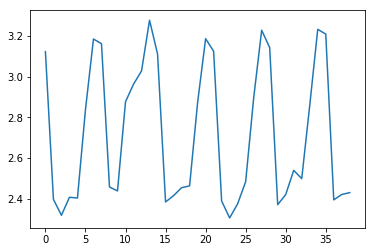

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.986364   
air_0164b9927d20bcc3_2017-04-23              1.411235   
air_0241aa3964b7f861_2017-04-23              2.346492   
air_0328696196e46f18_2017-04-23              2.097525   
air_034a3d5b40d5b1b1_2017-04-23              3.480843   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.288981  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.101017  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.448853  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.145981  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.487099

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l3_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')